# Simple Linear Model Assignment no-1

## Change the learning rate for the optimizer

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
%matplotlib inline

### Loading in the datasets

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


### Creating the training set

In [3]:
X_train = data.train.images
y_train = data.train.labels
y_train_class = np.argmax(y_train, axis=1)

In [4]:
y_train_class[:9]

array([7, 3, 4, 6, 1, 8, 1, 0, 9])

In [5]:
y_train_class[0]

7

### Creating the testing set

In [32]:
data.test.cls = np.array([l.argmax() for l in data.test.labels])
X_test = data.test.images
y_test = data.test.labels
y_test_class = np.argmax(y_test, axis=1)

In [7]:
y_test[:3]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [8]:
y_test_class[:3]

array([7, 2, 1])

### Creating some hyperparameters

In [9]:
num_classes = 10
image_shape = (28, 28)
image_shape_flat = 28 * 28
batch_size = 100

In [12]:
def plot_images(images, true_class, pred_class=None):
    assert len(images) == len(true_class) == 9
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(image_shape), cmap='binary')
        if pred_class is None:
            x_label = 'True: {}'.format(true_class[i])
        else:
            x_label = 'True: {}, Predicted: {}'.format(true_class[i], pred_class[i])
        ax.set_xlabel(x_label)
        ax.set_xticks([])
        ax.set_yticks([])

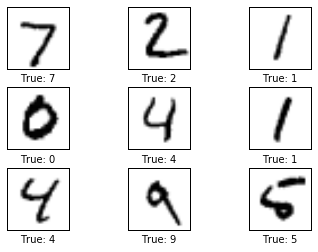

In [13]:
images = X_test[:9]
true_class = y_test_class[:9]
plot_images(images=images, true_class=true_class)

### Define Linear Model's placeholder

In [14]:
X = tf.placeholder(tf.float32, [None, image_shape_flat])
y = tf.placeholder(tf.float32, [None, num_classes])
y_class = tf.placeholder(tf.int64, [None])

### Define Linear Model's variables (weights `W` and biases `b`)

In [18]:
W = tf.Variable(tf.zeros([image_shape_flat, num_classes]))
b = tf.Variable(tf.zeros([num_classes]))

In [20]:
logits = tf.matmul(X, W) + b

In [21]:
y_pred = tf.nn.softmax(logits)

In [23]:
y_pred_class = tf.argmax(y_pred, dimension=1)

In [24]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)

In [25]:
cost = tf.reduce_mean(cross_entropy)

In [53]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(cost)

In [27]:
correct_prediction = tf.equal(y_class, y_pred_class)

In [29]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Running the computation Graph

In [30]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

### Definition of some helper function

In [54]:
def optimize(num_iterations):
    for i in range(num_iterations):
        feed_dict = {X: data.train.images, y:data.train.labels}
        sess.run(optimizer, feed_dict)

In [33]:
feed_dict_test = {X: data.test.images, y:data.test.labels, y_class: data.test.cls}

In [34]:
def print_accuracy():
    acc = sess.run(accuracy, feed_dict_test)
    print('Accuracy: {:.1%}'.format(acc))

In [41]:
def print_confusion_matrix():
    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the predicted classifications for the test-set.
    cls_pred = sess.run(y_pred_class, feed_dict=feed_dict_test)

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

In [46]:
def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = sess.run([correct_prediction, y_pred_class],
                                    feed_dict=feed_dict_test)

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                true_class=cls_true[0:9],
                pred_class=cls_pred[0:9])

In [47]:
def plot_weights():
    # Get the values for the weights from the TensorFlow variable.
    w = sess.run(W)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(image_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])

### Running the model's accuracy before training

In [48]:
print_accuracy()

Accuracy: 9.8%


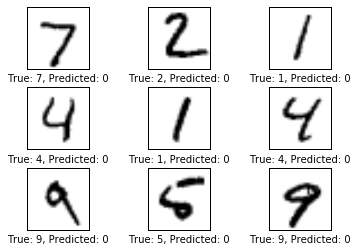

In [49]:
plot_example_errors()

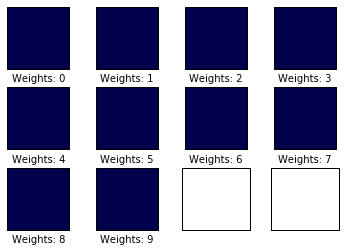

In [50]:
plot_weights()

### Training with one iterations

In [55]:
optimize(1)

In [56]:
print_accuracy()

Accuracy: 67.0%


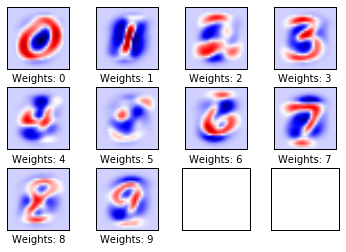

In [57]:
plot_weights()

### Optimization with 10 iterations

In [58]:
optimize(9) # 9 + 1 = 10 iterations

In [59]:
print_accuracy()

Accuracy: 69.7%


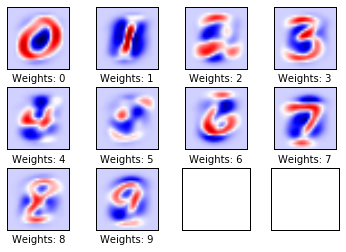

In [60]:
plot_weights()

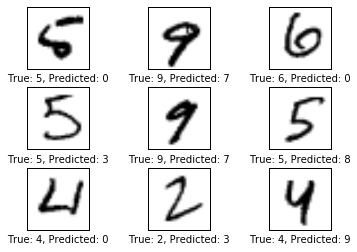

In [61]:
plot_example_errors()

### Optimization after 100 iterations

In [62]:
optimize(90) # 90 + 10 = 100 iterations

Accuracy: 79.1%


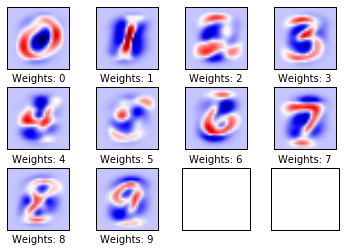

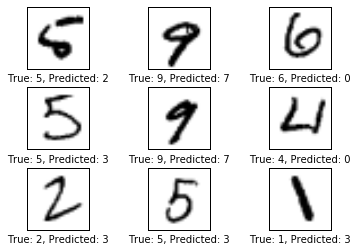

In [63]:
print_accuracy()
plot_weights()
plot_example_errors()